In [1]:
import numpy as np 
import pandas as pd
import glob, os, json
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics.pairwise import cosine_similarity


## Mixed-effect analysis

### aggregate similarity data

In [2]:
sub_folders = glob.glob('./data/sub*')
task_names = ['walking+practice', 'walking+memory', 'walking+nomemory']

similarity = []
sub_id = []
task = []
for sub_folder in sub_folders:
    sub_name = os.path.basename(sub_folder)
    for task_name in task_names:
        data_dir = f'{sub_folder}/gaze_angle_{task_name}.npy'
        if os.path.exists(data_dir):
            gaze_angle = np.load(data_dir)
            histograms = [h[0] for h in gaze_angle]
            similarity_matrix = cosine_similarity(histograms)

            # convert similarity matrix to long format
            n_input = len(np.tril(similarity_matrix).flatten())
            sub_id.extend([sub_name] * n_input)
            task.extend([task_name] * n_input)
            similarity.extend(np.tril(similarity_matrix).flatten())
        
df = pd.DataFrame({
    'subject_id': sub_id,
    'task': task,
    'similarity': similarity
})



### perform mixed-effect analysis

In [ ]:
import statsmodels.stats.multicomp as multi

# Mixed model 
df['task'] = df['task'].astype('category')
model = smf.mixedlm("similarity ~ task", df, groups=df['subject_id'])
result = model.fit()
print(result.summary())



               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    similarity
No. Observations:      13932      Method:                REML      
No. Groups:            15         Scale:                 0.1042    
Min. group size:       648        Log-Likelihood:        -4030.8168
Max. group size:       972        Converged:             Yes       
Mean group size:       928.8                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.228    0.006 39.482 0.000  0.217  0.239
task[T.walking+nomemory]  0.007    0.007  1.126 0.260 -0.005  0.020
task[T.walking+practice] -0.004    0.007 -0.524 0.600 -0.017  0.010
Group Var                 0.000    0.000                           

        Multiple Comparison of Means - Tukey HSD, FWER=0.05   

/home/gru/anaconda3/envs/jiwon_pupil/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/gru/anaconda3/envs/jiwon_pupil/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gru/anaconda3/envs/jiwon_pupil/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Postdoc Tukey test

In [37]:
## Posthoc analysis
import statsmodels.stats.multicomp as mc

# First, aggregate data to get means by subject and task
means_by_subject_task = df.groupby(['subject_id', 'task'])['similarity'].mean().reset_index()
means_by_subject_task_clean = means_by_subject_task.dropna(subset=['similarity', 'task'])

# Perform Tukey's HSD test
tukey = mc.pairwise_tukeyhsd(endog=means_by_subject_task_clean['similarity'], 
                             groups=means_by_subject_task_clean['task'],
                             alpha=0.05)

# Print the results
print("Tukey HSD Results:")
print(tukey)

Tukey HSD Results:
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------
  walking+memory walking+nomemory   0.0074 0.6082 -0.0114 0.0261  False
  walking+memory walking+practice  -0.0032 0.9181 -0.0226 0.0163  False
walking+nomemory walking+practice  -0.0105 0.3948   -0.03 0.0089  False
-----------------------------------------------------------------------


/tmp/ipykernel_1396017/2443364478.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_by_subject_task = df.groupby(['subject_id', 'task'])['similarity'].mean().reset_index()


## Correlation between conditions


Correlation Matrix across Subjects:
task              walking+memory  walking+nomemory  walking+practice
task                                                                
walking+memory          1.000000          0.523055          0.402057
walking+nomemory        0.523055          1.000000          0.470612
walking+practice        0.402057          0.470612          1.000000

Correlations with p-values:
walking+memory vs walking+nomemory: r = 0.523, p = 0.045
walking+memory vs walking+practice: r = 0.402, p = 0.173
walking+nomemory vs walking+practice: r = 0.471, p = 0.105


/tmp/ipykernel_1396017/661190302.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(index='subject_id', columns='task', values='similarity', aggfunc='mean')


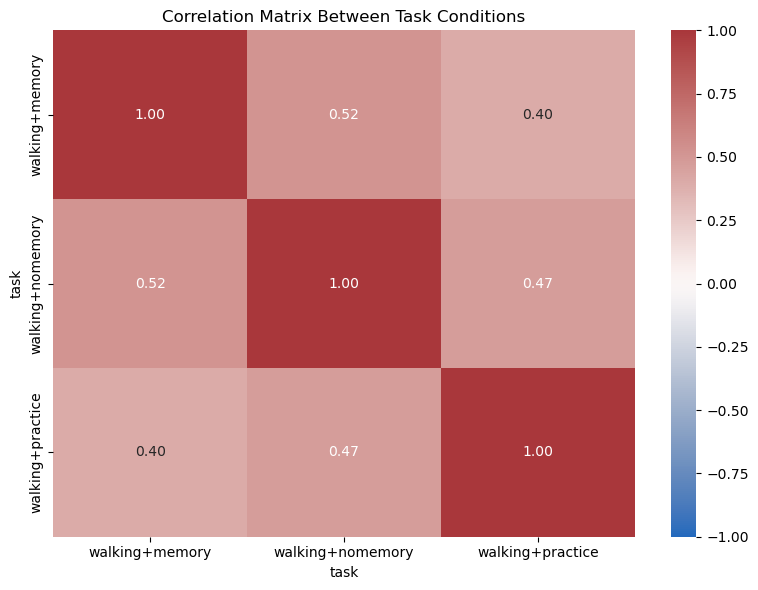

In [35]:
from scipy.stats import pearsonr

# Pivot the DataFrame to get tasks as columns and subjects as rows
pivot_df = df.pivot_table(index='subject_id', columns='task', values='similarity', aggfunc='mean')

# Calculate the correlation matrix across subjects
correlation_matrix = pivot_df.corr(method='pearson')

# Print the correlation matrix
print("\nCorrelation Matrix across Subjects:")
print(correlation_matrix)
print("\nCorrelations with p-values:")
task_names = pivot_df.columns
for i, task1 in enumerate(task_names):
    for task2 in task_names[i+1:]:
        # Drop rows with NaN values in either task1 or task2
        valid_rows = pivot_df[[task1, task2]].dropna()
        
        # Calculate Pearson correlation coefficient and p-value if there are valid rows
        if len(valid_rows) > 1:  # Check if there are enough data points
            r, p = pearsonr(valid_rows[task1], valid_rows[task2])
            print(f"{task1} vs {task2}: r = {r:.3f}, p = {p:.3f}")

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='vlag', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix Between Task Conditions')
plt.tight_layout()
plt.show()